In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import vgg16
import cv2
import os

## Unit test

In [ ]:
train_path = "./train/"
test_path = "./test/"

In [ ]:
batch_images = np.random.randn(3, 224, 224, 3)
batch_labels = np.ones((3, 1), dtype=np.int64)
print(batch_images.shape)
print(batch_labels.shape)

In [ ]:
tf.reset_default_graph()
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        vgg = vgg16.Vgg16("./vgg16.npy")
        vgg.build()
        sess.run(tf.global_variables_initializer())
        prediction, loss = sess.run([vgg.prediction, vgg.loss], feed_dict={"images:0": batch_images,
                                                                             "labels:0": batch_labels})
        print(prediction)
        print(loss)

## Train model

In [2]:
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import vgg16
import cv2
import os

In [2]:
def generate_label(images_list):
    label = np.array([ 1  if 'cat' in path else 0 for path in train_images_list])
    label = label.reshape((-1, 1))
    return label

def load_image(image_path):
    image = cv2.imread(image_path)
    
    short_edge = min(image.shape[:2])

    yy = int((image.shape[0] - short_edge) / 2)
    xx = int((image.shape[1] - short_edge) / 2)
    crop_image = image[yy: yy + short_edge, xx: xx + short_edge]
    
    resized_image = cv2.resize(crop_image, (224, 224)) 
    
    return resized_image

def get_batches(x, y, batch_size=32):
    num_rows = y.shape[0]
    num_batches = num_rows // batch_size

    if num_rows % batch_size != 0:
        num_batches = num_batches + 1
    
    for batch in range(num_batches):
        yield x[batch_size * batch: batch_size * (batch + 1)], y[batch_size * batch: batch_size * (batch + 1)]

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


In [3]:
train_path = "./train/"
test_path = "./test/"

In [4]:
train_images_list = [train_path + i for i in os.listdir(train_path)]
# train_images_list = train_images_list[:10000]
labels = generate_label(train_images_list)
images = np.array([load_image(f) for f in train_images_list])

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
train_indices, val_indices = next(splitter.split(images, labels))

train_images, train_labels = images[train_indices], labels[train_indices]
val_images, val_labels = images[val_indices], labels[val_indices]

In [5]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(22500, 224, 224, 3)
(22500, 1)
(2500, 224, 224, 3)
(2500, 1)


# Train Model

In [18]:
num_epochs = 5
batch_size = 16
iteration = 0
accuracy_print_step = 10
max_acc = 0
accuracy_list = []

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    
    with tf.device(None):
        with tf.Session() as sess:
            vgg = vgg16.Vgg16("./vgg16.npy")
            vgg.build()
            init = tf.global_variables_initializer()
            sess.run(init)
            print ("Initialized")
            saver = tf.train.Saver()
            for epoch in range(num_epochs):
                for batch_train_images, batch_train_labels in get_batches(train_images, train_labels, batch_size=batch_size):
                    feed_dict = {"images:0" : batch_train_images, "labels:0" : batch_train_labels}
                    _, l, tr_accuracy = sess.run([vgg.optimizer, vgg.loss, vgg.accuracy], feed_dict=feed_dict)
                    accuracy_list.append(tr_accuracy)

#                 saver = tf.train.Saver(max_to_keep=1)
#                 if tr_accuracy > max_acc:
#                     max_acc = tr_accuracy
#                     saver.save(sess, './parameter/vgg16_v1.ckpt', global_step = epoch + 1)
            saver.save(sess, './parameter/vgg16_v2.ckpt')
    #                 iteration += 1
    #                 if iteration % accuracy_print_step == 0:
    #                     feed_dict = {"images:0" : val_images, "labels:0" : val_labels}
    #                     val_accuracy = sess.run(vgg.accuracy, feed_dict=feed_dict)
    #                     print('train accuracy:{} \nvalid accuracy:{}'.format(tr_accuracy, val_accuracy))

npy file loaded
Initialized


In [10]:
np.mean(accuracy_list)

0.9766169

## Predict

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    vgg = vgg16.Vgg16("./vgg16.npy")
    vgg.build()
    saver = tf.train.Saver()
    saver.restore(sess, "./parameter/vgg16_v2.ckpt")
    
    feed_dict ={"images:0" : train_images[0].reshape((1, 224, 224, 3))}
    print(sess.run(vgg.prediction, feed_dict))

npy file loaded
INFO:tensorflow:Restoring parameters from ./parameter/vgg16_v2.ckpt
[[1.]]


## View

In [24]:
def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    plt.close()

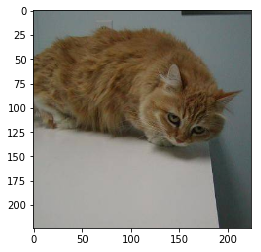

In [25]:
show_img(train_images[0])